# Astroturfing on Reddit

https://github.com/ageil/Probabilistic-Programming

## Motivation

The recent focus on fake news in Western democracies within social sciences has also given rise to the related notion of astroturfing. As defined by Zhang et al. (2013):

> "Online astroturfing refers to coordinated campaigns where messages supporting a specific agenda are distributed via the Internet. These messages employ deception to create the appearance of being generated by an independent entity."

In this perspective, astroturfing can be viewed as a mechanism that enables the initial spread of a fake news item on social media. By initially associating a fake news story with artificial user activity to mimic grassroots activity, the story may gather increased attention from regular users and achieve greater user engagement over the full duration of its lifespan. In this study, we will analyze whether the effect of a Reddit post's initial user engagement on total user engagement is dependent on the specific type of news story.

---

## Data

<img src="../output/data_diagram_final_annotated.png" width="400" align="center"/>

To construct the dataset, we collect 695,147,095 Reddit posts from [Pushshift](https://pushshift.io). This constitutes every submission made between January 2016 and April 2020. We also rely on [the ClaimReview Project](https://www.claimreviewproject.com), a collective of verified journalists and fact-checkers, to obtain structured reviews of news items by scraping 151,025 ClaimReviews from [Google Fact Check Explorer](https://toolbox.google.com/factcheck/explorer) spanning from January 2015 to October 2020.

Merging these two datasets, we obtain two collections of post-review pairs: One representing the Reddit posts that link to articles that have also been reviewed by fact checkers; and another representing the posts that link directly to the corrective review articles themselves.

Final counts are reflected in the figure above.

In [1]:
import sys
sys.path.insert(0, '../model')

from model_utils import print_labeled_type_coefs
from inference import plot_losses
from evaluation import (
    plot_predictions, plot_predictions_by_subreddit, plot_ppc_grid, 
    plot_pp_hdi, plot_expectations, print_results
)

from ModelManager import ModelManager

First, we load in our data, unpack it, and process it for use in our models.

In [2]:
mm = ModelManager()

In [3]:
mm.load_data()
mm.transform_data()

Finally, we split our data into test and train sets. Note that we use the test data only for the final evaluation and comparison of our models.

In [5]:
mm.split_data(train_frac=0.7)

----

## Models

In modeling the total engagement of a Reddit post, we start with the simplest possible model first and gradually build on more levels. In the first section, we simply analyze the expected engagement by type to expose any explicit biases. 

### Expectations

As an initial check, we first calculate the expected total engagement of each type. The plot shows the distribution of total engagement over the posts in each content type group.

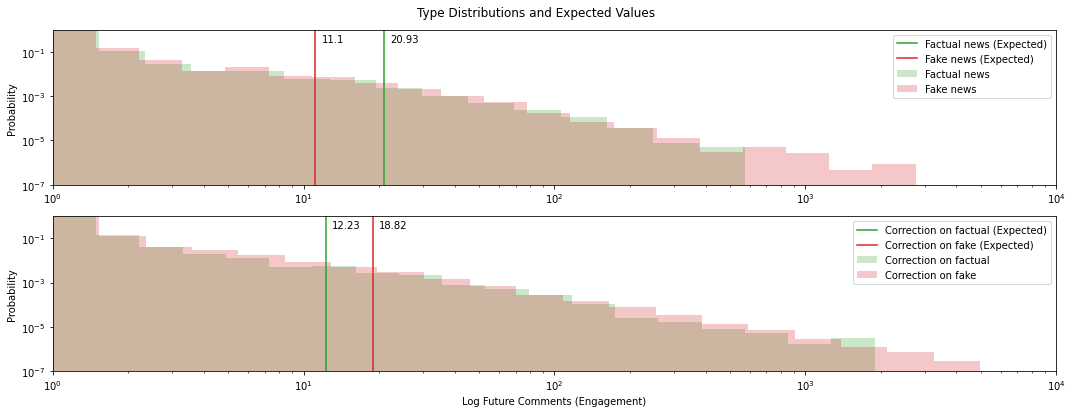

In [6]:
plot_expectations(mm.y, mm.p_types)

On expectation, factual news seem to generate the most comments, closely followed by corrective articles on fake news. Surprisingly, the least overall engagement seems to correspond to fake news articles.

To analyze these differences further, we will now turn to actual model building.

### Type level

In order to capture the difference in how different types of posts gain exposure, we next model each post as belonging to one of four "type" groups: 
1. Factual News
2. Fake News
3. Review of Factual News
4. Review of Fake News

Because each post belongs to exactly one of these type groups, we can depict this model graphically as shown below:

<img src="../output/model_type.png" width="400" align="right"/>
<img src="../output/eq_type.png" width="400" align="left"/>

Note that for these and all other regressions run, we run two parallel GLMs where $y$ is the value before getting transformed according to the link function. One regression is a Poisson regression for the "rate", and the other is a logistic regression for the "gate" parameter, the additional probability of getting a zero observation, in order to model engagement as coming from a zero-inflated Poisson.

Let's start by fitting our model.

In [7]:
type_losses = mm.run_svi("type", num_iters=3000, lr=1e-2, zero_inflated=True)

Visualizing the losses, we build confidence that our model has converged.

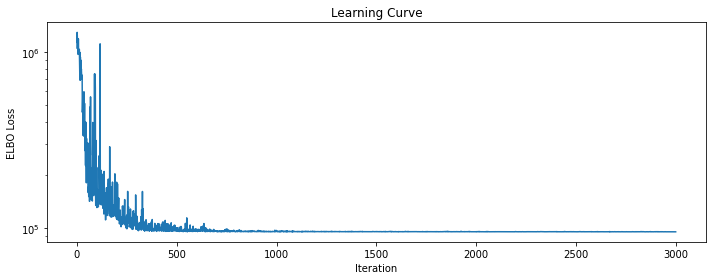

In [8]:
plot_losses(type_losses, filename="type_losses.png")

Below, we can see differences between groups. Note that among posts with no comments in the first hour, reviews of fake news seem to generate the most discussion. This may be due to the delayed effect of users having to more thoroughly review and reflect on the correction articles before commenting.

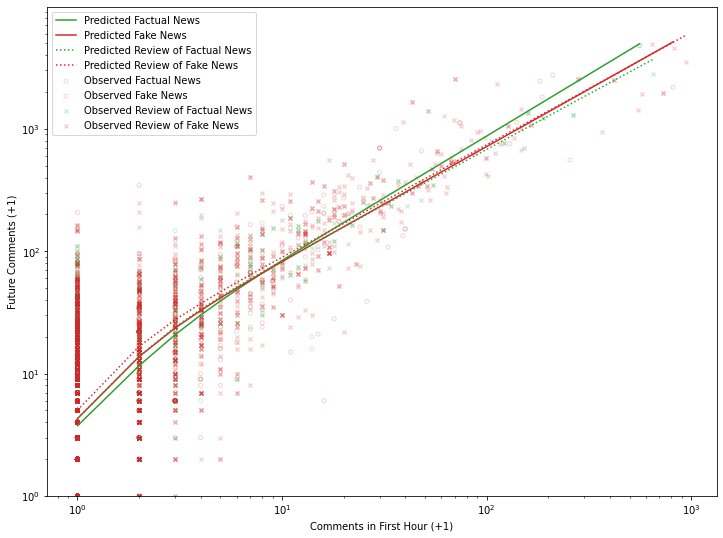

In [9]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="type_predictions.png")

Let's again take a closer look at our model's posterior predictive distribution.

In [10]:
posterior_predictive_samples = mm.get_samples("type", zero_inflated=True, num_samples=1000)

In the Highest Density Interval (HDI) plot, we first notice that for large counts of inital comments, we see a tight band. This may be explained through SVI's tendency to underestimate variance. At smaller initial comment counts, we notice a sharp drop in the lower band to include zero. This is a consequence of our choice of response variable distribution, the zero-inflated Poisson.

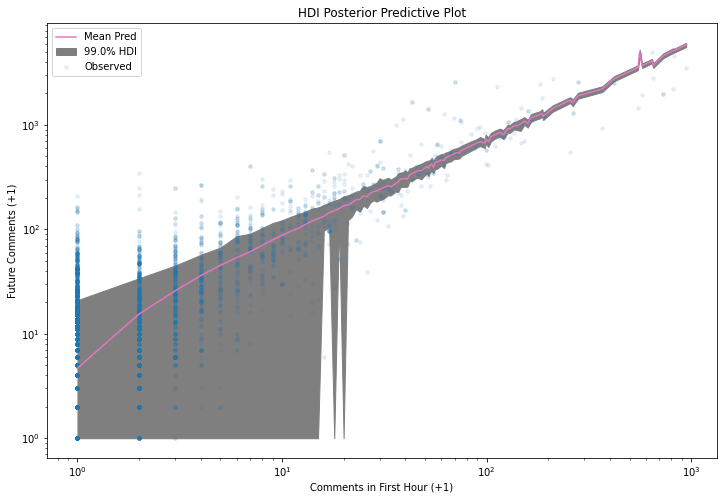

In [11]:
plot_pp_hdi(posterior_predictive_samples, mm.original_p_data_train, mm.y_train, filename="type_hdi.png")

In our PPCs, we see that our model is able to balance between non-zero and zero predictions, yet for non-zero predictions, seems to overestimate. Finally, we overestimate the variance, possibly due to our zero-inflated model creating a bimodal distribution.

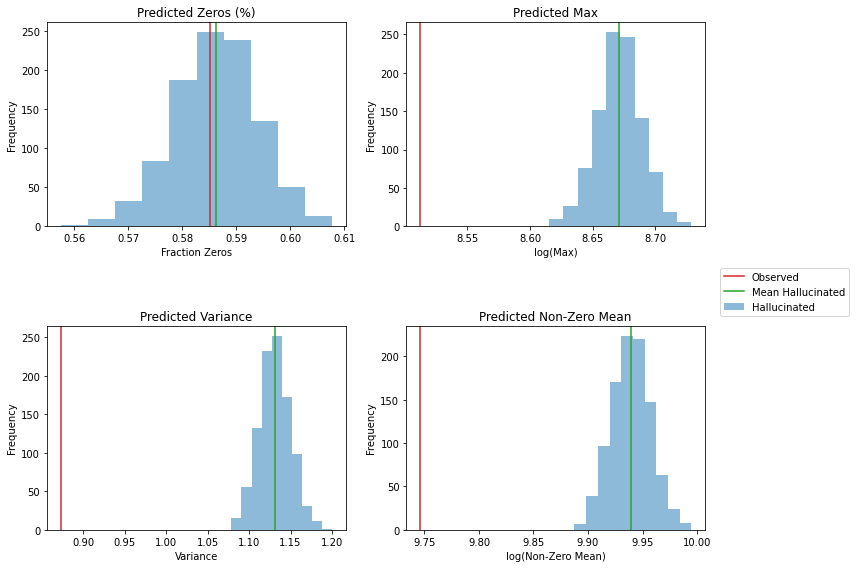

In [12]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="type_ppc.png")

To evaluate the overall fit of our model to the training data, we calculate $R^2$ on both the original count data and the log transformed non-zero count data.

The fairly large $R^2$ but lower $R^2$ log non-zero suggests that this model decently captures variation among high-magnitude observations, but struggles with the larger variation at lower-magnitude non-zero observations.

In [13]:
mm.evaluate(y_pred, partition='train', model='type')
print_results(mm.results, partition="train")

                    type
----------------  ------
R^2                 0.72
R^2 log non-zero    0.56


In [14]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='type')

### Subreddit level

We expect that posts submitted to subreddits with similar subscriber counts may exhibit similar effects on engagement. Here, we use the number of subscribers the subreddit had at the time of submission to partition the posts into evenly sized groups at the subreddit-level.

<img src="../output/model_subreddit.png" width="400" align="right"/>
<img src="../output/eq_subreddit.png" width="400" align="left"/>

Again, we first fit our model to the training data.

In [15]:
subreddit_losses = mm.run_svi("subreddit", num_iters=3000, lr=1e-2, zero_inflated=True)

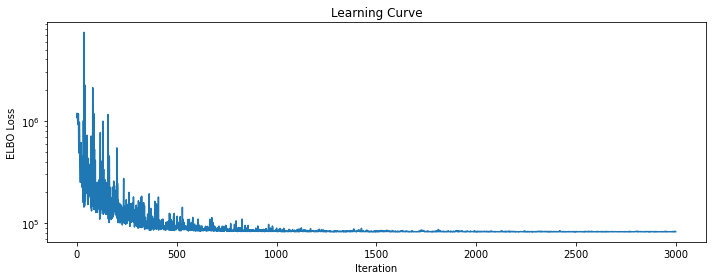

In [16]:
plot_losses(subreddit_losses, filename="subreddit_losses.png")

Checking the convergence of our model, we proceed to plot the predictions against the actual observations.

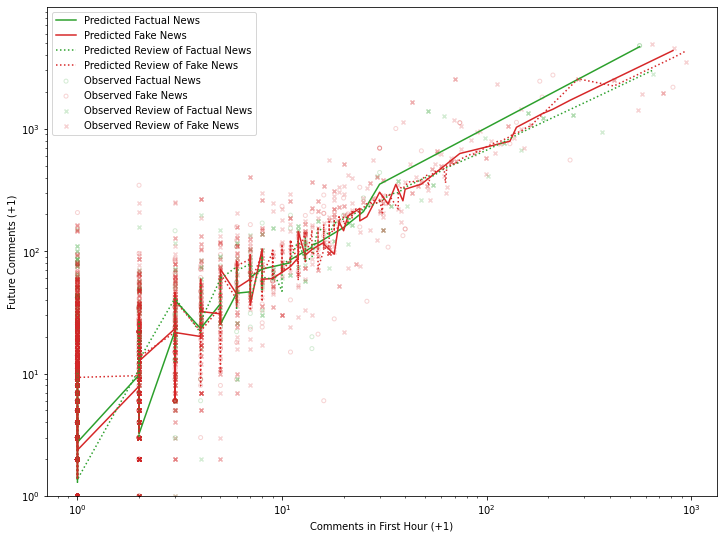

In [17]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="subreddit_predictions.png")

In [18]:
posterior_predictive_samples = mm.get_samples("subreddit", zero_inflated=True, num_samples=1000)

Now, looking at the PPCs, we see dramatic improvement from the type-level. Our predicted fraction of zeros, maximum, and non-zero mean observations all lie well within the density of our hallucinated data. However, we still overestimate the variance.

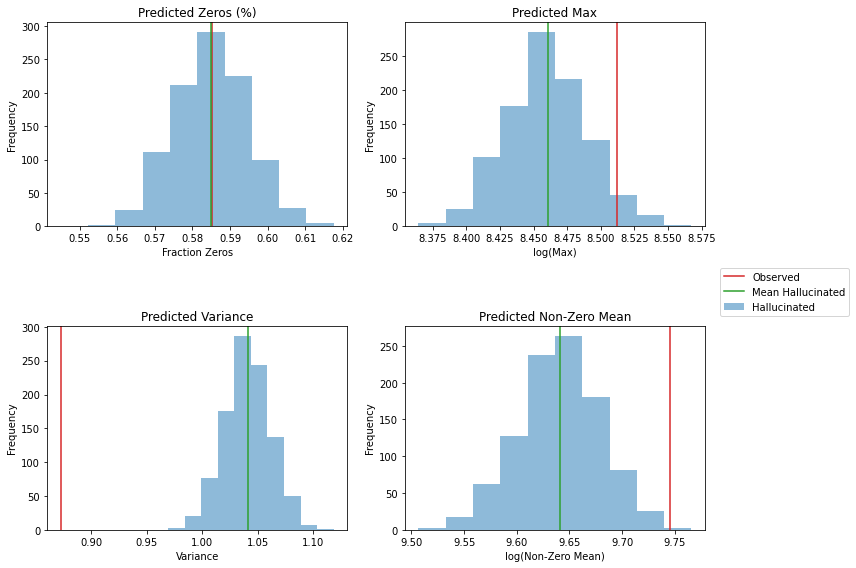

In [19]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="subreddit_ppc.png")

Another way to visualize our model is by inspecting each of the 9 groups at the subreddit level. Here we can more clearly see how the groups may now exhibit different slopes and offsets.

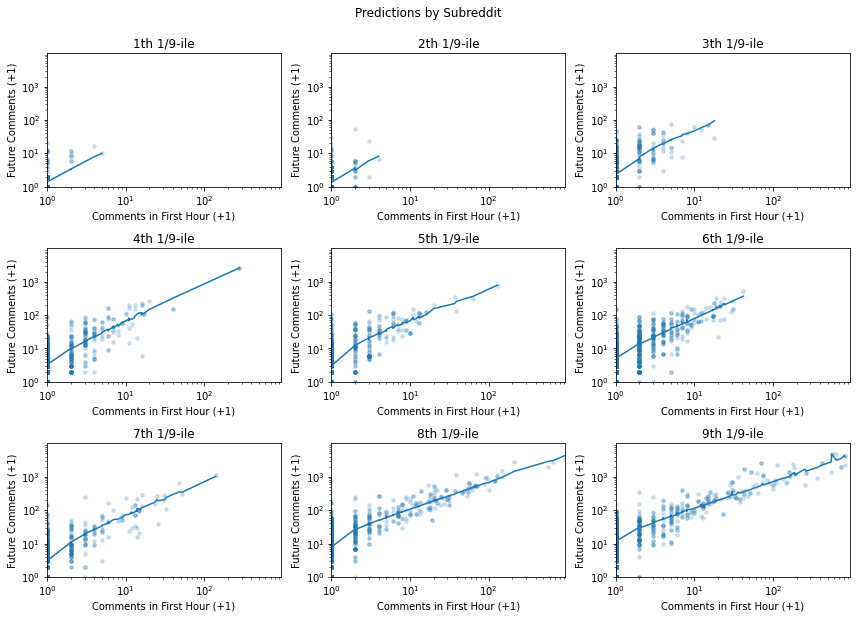

In [20]:
plot_predictions_by_subreddit(mm.y_train, mm.original_p_data_train, mm.p_subreddits_train, y_pred, filename="subreddit_by_subreddit.png")

Because this model captures subreddit-level variation, we witnessed improvements across all of our fit metrics.

In [21]:
mm.evaluate(y_pred, partition='train', model='subreddit')
print_results(mm.results, partition='train')

                    type    subreddit
----------------  ------  -----------
R^2                 0.72         0.82
R^2 log non-zero    0.56         0.59


In [22]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='subreddit')

### Complete model

In addition to belonging to a single type and subreddit, each post refers to a specific story. Depending on the author of the story and which countries the story is relevant to, we will model the story-level variation. Note that multiple types may link to a single story, giving us this model:

<img src="../output/model_complete.png" width="400" align="right"/>
<img src="../output/eq_complete.png" width="400" align="left"/>

In [23]:
complete_losses = mm.run_svi("complete", num_iters=3000, lr=1e-2, zero_inflated=True)

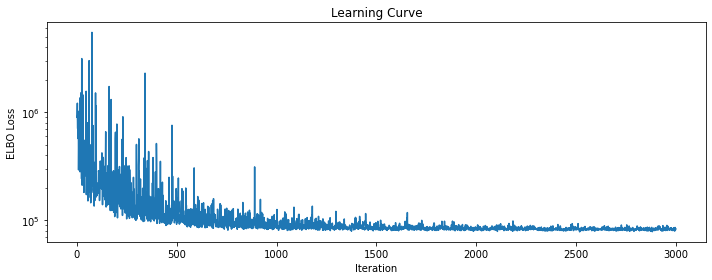

In [24]:
plot_losses(complete_losses, filename="complete_losses.png")

Again, our SVI converges.

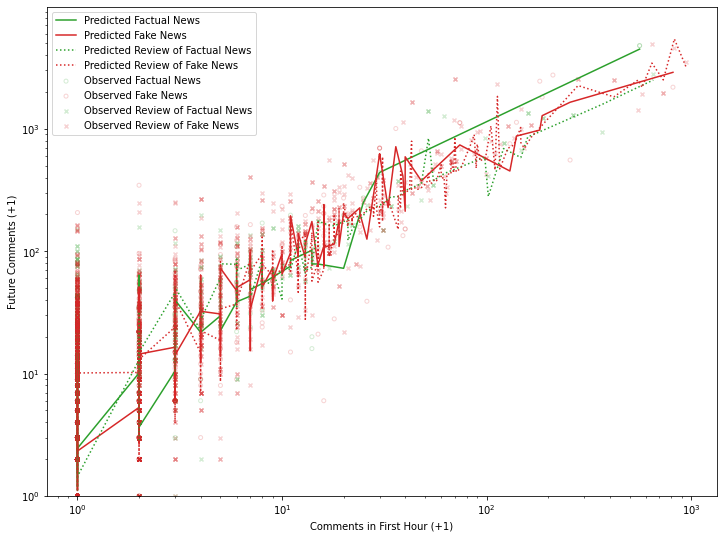

In [25]:
y_pred = mm.get_y_pred(use_train=True)
plot_predictions(mm.y_train, mm.original_p_data_train, mm.p_types_train, y_pred, filename="complete_predictions.png")

The following coefficients describe the expected value of the total coefficient on the log 1st Hour Comments in the post-level regression for a given type.

Comparing factual and fake news, we notice the fake coefficient is considerably higher. This means that while we see an approximate .93% increase in future comments for a 1% increase in initial comments for fake news, we only see an approximate .78% increase for factual news. Instead, the growth rate for fake news is reminiscent of those of Reviews.

In [26]:
print_labeled_type_coefs(mm.p_types, mm.p_stories, mm.p_subreddits, mm.t_data, mm.s_data, mm.r_data)

log 1st Hour Comments Coefficient for Type:
	Factual News: 0.782
	Fake News: 0.931
	Review of Factual News: 0.939
	Review of Fake News: 0.934


In [27]:
posterior_predictive_samples = mm.get_samples("complete", zero_inflated=True, num_samples=1000)

Now, we see much broader bands in the HDI plot, covering more of our observations. This could be a good sign, as the output of our model looks more like the observed distribution, but it also may allow our model to make predictions that are less likely.

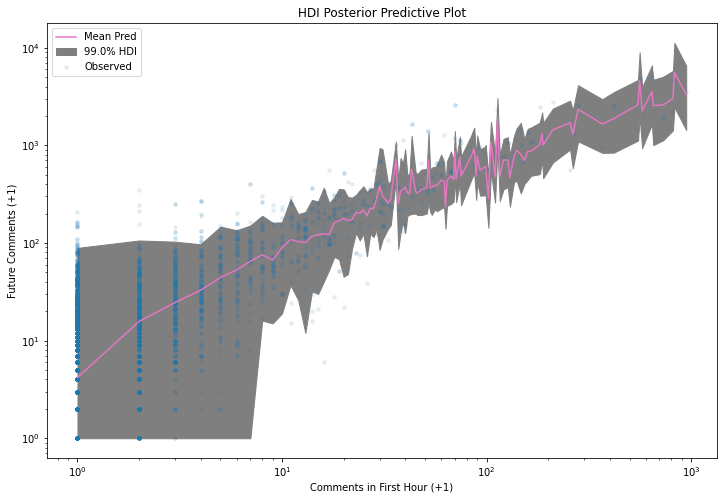

In [28]:
plot_pp_hdi(posterior_predictive_samples, mm.original_p_data_train, mm.y_train, filename="complete_hdi.png")

In the PPCs, despite the broader HDI bands, the observed statistics still seem to align with the statistics of the posterior predictive distributions generated from the training data. Again, we still struggle with overestimation of variance.

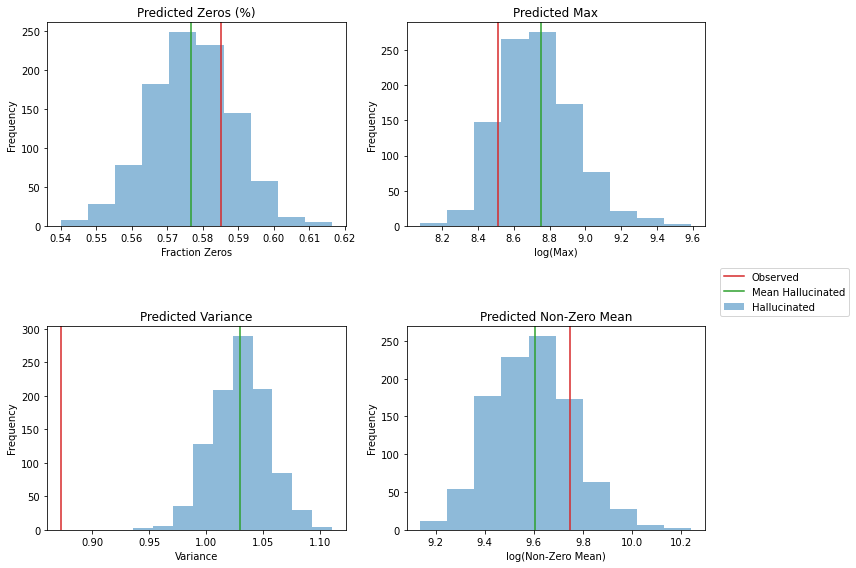

In [29]:
plot_ppc_grid(posterior_predictive_samples, mm.y_train, filename="complete_ppc.png")

In [30]:
mm.evaluate(y_pred, partition='train', model='complete')

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.72         0.82        0.88
R^2 log non-zero    0.56         0.59        0.61


In [31]:
y_pred = mm.get_y_pred(use_train=False)
mm.evaluate(y_pred, partition='test', model='complete')

## Comparison

Overall, we seem to benefit from the complexity of the subreddit and story levels. We see clear improvements on both the train and test data as we add additional levels to our model. Further, we see no noticeable drop in fit when moving from the train to test data, suggesting that each of our models is capable of generalizing to unseen data.

In [32]:
print_results(mm.results, partition="train")

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.72         0.82        0.88
R^2 log non-zero    0.56         0.59        0.61


In [33]:
print_results(mm.results, partition="test")

                    type    subreddit    complete
----------------  ------  -----------  ----------
R^2                 0.86         0.87        0.89
R^2 log non-zero    0.58         0.6         0.61


---

# Conclusion

Ultimately, we have created three models, each building off of the next, in order to model the engagement of a reddit post. The type level, while having the simplest explanation of how different types of posts grow, was unable to capture much of the inter-type variation desired, poorly modeling posterior predictive distribution. Exploiting the hierarchical subreddit structure, we saw improvements in some key statistics of the posterior predictive. Finally, by modeling each post as being about a story, we were able to predict engagement values in a wider range, giving us the best fit and a posterior predictive most in-line with our observations.

From our complete model, we observed a stark difference in sensitivity to first-hour comments between factual and fake news articles. In fact, fake news articles were more sensitive to these initial comments, exhibiting growth rates more similar to those of review articles. We suspect this may be due to controversy-driven discussion found in both fake news and corrective review articles. 

---

# References

- Zhang, J., Carpenter, D., & Ko, M. (2013). Online astroturfing: A theoretical perspective.

---